<a href="https://colab.research.google.com/github/jlcases/Python/blob/master/Clustering_headings_y_enlaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
!pip install nltk
!pip install gensim
from gensim.models import Word2Vec
from unicodedata import normalize
import spacy
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download es_core_news_sm
import es_core_news_sm
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
from google.colab import data_table
import numpy as np
from sklearn import preprocessing
from google.colab import drive
import os
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     |████████████████████████████████| 16.2 MB 65.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
drive.mount('/content/drive')
print(os.getcwd())
os.chdir('drive/MyDrive/SEO Python')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/SEO Python


In [ ]:
class pagina():
    def __init__(self, url):
        self.url = url
        self.texto = ""
        self.enlaces  = []
        self.headings = []

class serp():
     
    # init method or constructor
    def __init__(self, query):
        self.query = query.replace(" ", "+")
        self.ok = False
        self.incidendias = []
        self.paginas = []
        self.start()

    def start(self):
        URL = "https://www.google.com/search?hl=es&gl=es&q=%s&oq=%s" % (self.query, self.query)
        headers =  {"user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36"}
        enlacesSerp = []
        resp = requests.get(URL, headers = headers)
        if resp.status_code == 200: 
            soup = BeautifulSoup(resp.content, "html.parser")
            links = soup.find_all("div", {"class" : "g"})
            print("Procesando urls:")
            for x in links:
                link = x.find("a")['href']
                #corrijo feature snippet
                if "#:~:text" in link: 
                    link = link.split("#:~:text")[0]
                if link.startswith("/"):continue
                print(link)

                if not link in enlacesSerp:
                    enlacesSerp.append(link)
                    
                    try:
                      resp = requests.get(link, headers = headers, timeout=10)
                         
                    except Exception as e:
                      self.incidendias.append(f"timeout error: {str(e)} url: {link}")

                    soup = BeautifulSoup(resp.content, "html.parser")

                    if resp.status_code == 200:
                        pag = pagina(link)
                        
                        #elimino scrips
                        for s in soup.find_all(['script', 'style']):
                            s.extract()
                        
                        #recupero texto
                        texto = ""
                        tag = soup.body
                        for string in tag.strings:
                            texto = texto + " " + string
                        pag.texto = texto

                        #recupero enlaces
                        for en in soup.find_all("a", href=True):
                            if "#" in en["href"] or "http" in en["href"]:continue
                            if en.text not in pag.enlaces:
                                pag.enlaces.append(en.text)

                        #recupero headings
                        for heading in soup.find_all(encabezados):
                            if heading.text not in pag.headings:
                                pag.headings.append([heading.name, heading.text.strip('\n').strip()])
                        
                        self.paginas.append(pag)
                    else:
                        self.incidendias.append(f"Status code: {resp.status_code} url: {link}")

            if len(self.paginas) < 5:
                self.ok = True
                self.incidendias.append("Menos de 5 resultados escrapeados")
            else:
                self.ok = True
 
        else:
            self.ok = False

        #reporto incidencias scrapeo
        print(str(len(self.paginas)) + " páginas escrapeadas correctamente")

        if len(self.incidendias) > 0:
            print("Incidencias")
            print("-----------")
            for x in self.incidendias:
                print(x)

def lematizarFrase(frase):
    doc = nlp(frase)
    lematizado = [token.lemma_ for token in doc]
    return " ".join(lematizado)

def quitarAcentos(frase):
  frase = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", frase), 0, re.I
    )
  frase = normalize( 'NFC', frase)
  return frase

def quitarStopWords(frase):
  tokenizado = frase.split()
  tokenizado = [w for w in tokenizado if w not in stopwords.words('spanish')]
  return " ".join(tokenizado)

def limpiarBasico(frase, lemat = True):
    frase = re.sub('[^a-zA-ZÀ-ÿ\u00f1\u00d1]', ' ', frase)
    frase = re.sub(r'\s+', ' ', frase)
    frase = frase.replace("  ", " ").strip()
    if lemat == True: frase = lematizarFrase(frase)
    frase = quitarAcentos(frase)
    return frase

def limpia(texto):
    procesando = limpiarBasico(texto)
    procesando = procesando.lower()
    #procesando = quitarAcentos(procesando)
    procesando = procesando.replace("(", "").replace(")", "")
        
    frases = nltk.sent_tokenize(procesando)
    tokenizado = [nltk.word_tokenize(sent) for sent in frases]

    # Removing Stop Words
    for i in range(len(tokenizado)):
        tokenizado[i] = [w for w in tokenizado[i] if w not in stopwords.words('spanish')]
    return tokenizado

def limpiarFrase(frase, lemat = True):
    frase = frase.lower()
    frase = frase.replace("(", "").replace(")", "")
    frase = limpiarBasico(frase)
    frase = frase.split()
    frase = [x for x in frase if x in vocabulario]   
    return " ".join(frase).strip()

def puntuar(keyword, lista):
  for en in lista:
    palabrasRelev = [palabra for palabra in en[1].split()]
    res = round(modelo.n_similarity(keys, palabrasRelev),3)
    en.append(str(res))
  lista = sorted(lista, key=lambda x: x[2], reverse=True)
  return lista

def similitud(kw0, kw1):
  sinStop0 = quitarStopWords(kw0)
  limpio0 = limpiarFrase(sinStop0, lemat = False)

  sinStop1 = quitarStopWords(kw1)
  limpio1 = limpiarFrase(sinStop1, lemat = False)

  palabrasRelev0 = [palabra for palabra in limpio0.split()]

  palabrasRelev1 = [palabra for palabra in limpio1.split()]

  res = round(modelo.n_similarity(palabrasRelev1, palabrasRelev0),3)
  return res

def agrupar(lista0):
  lista = lista0.copy()
  headingsAgrupados = []
  while len(lista)>0:
    relacionados = []
    primero = lista.pop(0)
    palabrasPrimero = [palabra for palabra in primero[1].split()]
    
    for hea in list(lista):
      palabrasRelev = [palabra for palabra in hea[1].split()]
      res = round(modelo.n_similarity(palabrasPrimero, palabrasRelev),3)
      
      if res == 1:
        #print(str(res), palabrasPrimero, palabrasRelev)
        if hea[0] not in relacionados and hea[0] != primero[0]:
          relacionados.append(hea[0])
        lista.remove(hea)
    relacionados = " - ".join(relacionados)
    primero.append("")
    primero.append(relacionados)
    headingsAgrupados.append(primero)
  return headingsAgrupados

def pasarATabla(lista,columnas):
  lista = pd.DataFrame(lista, columns = columnas)
  lista = data_table.DataTable(lista, include_index=True, num_rows_per_page=20)
  display(lista)

def texto2Vector(texto, modelo, lemat = True):
  vector = np.zeros(modelo.vector_size)
  texto_limpio = limpiarFrase(quitarStopWords(texto), lemat = lemat)
  for palabra in texto_limpio.split():
    vector += modelo.wv[palabra]
  return vector

In [ ]:
# EMBEDDINGS = 'embeddings-l-model.vec'
# cantidad = 100000
# wordvectors = KeyedVectors.load_word2vec_format(EMBEDDINGS, limit=cantidad)

In [ ]:
keyword = 'order flow'
encabezados = ['h1', 'h2', 'h3']
scrap = serp(keyword)

EMBEDDINGS = 'embeddings-l-model.vec'
CANTIDAD = 100000



if scrap.ok == False:
    print("No se ha completado el scrap, se detiene el análisis => Sorry...")
    quit()

nlp = es_core_news_sm.load()
texto = ""
for p in scrap.paginas:
    texto = texto + " " + p.texto
texto = texto.strip()
textoLimpio = limpia(texto)
# word2vec = Word2Vec(textoLimpio, min_count=2, iter= 2)
# modelo = word2vec.wv
modelo = KeyedVectors.load_word2vec_format(EMBEDDINGS, limit=CANTIDAD)

vocabulario = modelo.index2word

headings = []
paginas2headings = {}
headings2paginas = {}

for pagina in scrap.paginas:
    for heading in pagina.headings:
      he = []
      he.append(heading[1].strip())
      sinStop = quitarStopWords(heading[1])
      he.append(limpiarFrase(sinStop))
      headings.append(he)
      paginas2headings[pagina.url] = he[0]
      headings2paginas[he[0]] = pagina.url

enlaces = []
for pagina in scrap.paginas:
    for enlace in pagina.enlaces:
      he = []
      he.append(enlace.strip())
      sinStop = quitarStopWords(enlace)
      he.append(limpiarFrase(sinStop))
      enlaces.append(he)

headings = [hea for hea in headings if hea[1].strip() !=""]
enlaces = [hea for hea in enlaces if hea[1].strip() !=""]

keys = [x for x in limpiarBasico(keyword).lower().split() if x in vocabulario]

headings = puntuar(keyword, headings)
enlaces = puntuar(keyword,enlaces)
headingsFinal = agrupar(headings)

#borro duplicados enlaces
enlaces2 = []
for enlace in enlaces:
  anchors = [x[0].lower() for x in enlaces2]
  if enlace[0].lower() not in anchors:
    enlaces2.append(enlace)
enlaces = enlaces2

headingsFinal = [heading[:5:2] for heading in headingsFinal]
enlacesFinal = [enlace[::2] for enlace in enlaces]

# pasarATabla(headingsFinal, ['Encabezado', 'Puntuación', 'Agrupados'])
# pasarATabla(enlacesFinal, ['Enlaces', 'Puntuación'])

Procesando urls:
https://traderprofesional.com/trading/order-flow/
https://experienciatopstep.com/vida-de-trader/que-es-el-order-flow-y-como-lo-uso/
https://www.novatostradingclub.com/trading/order-flow-o-flujo-de-ordenes-en-trading/
https://unespeculador.com/manualorderflow/
https://armagafx.com/que-es-order-flow/
https://areadeinversion.com/order-flow-que-es/
https://ninjatrader.com/es/Order-Flow-Trading
https://delta-value.com/que-es-order-flow/
8 páginas escrapeadas correctamente


# Clustering encabezados

In [ ]:
pdHeadingsFinal = pd.DataFrame(headingsFinal, columns = ['Encabezado', 'Puntuación', 'Agrupados'])
pdHeadingsFinal['Páginas'] = [headings2paginas.get(heading) for heading in pdHeadingsFinal['Encabezado']]
pdHeadingsFinal.head()

,Encabezado,Puntuación,Agrupados,Páginas
0,Order Flow – Imbalance,1.0,Order Flow +,https://unespeculador.com/manualorderflow/
1,¿Qué es order flow?,0.975,¿Qué es el Order Flow?,https://traderprofesional.com/trading/order-flow/
2,Obtenga Order Flow +,0.934,,https://ninjatrader.com/es/Order-Flow-Trading
3,Order Flow – Absorción/Contrapartida,0.933,,https://unespeculador.com/manualorderflow/
4,5. Significado de colores en Order Flow,0.931,,https://armagafx.com/que-es-order-flow/


In [ ]:
print('Todas las URL scrapeadas:')
for pagina in pdHeadingsFinal['Páginas'].unique():
  print(pagina)

Todas las URL scrapeadas:
https://unespeculador.com/manualorderflow/
https://traderprofesional.com/trading/order-flow/
https://ninjatrader.com/es/Order-Flow-Trading
https://armagafx.com/que-es-order-flow/
https://experienciatopstep.com/vida-de-trader/que-es-el-order-flow-y-como-lo-uso/
https://www.novatostradingclub.com/trading/order-flow-o-flujo-de-ordenes-en-trading/
https://delta-value.com/que-es-order-flow/
https://areadeinversion.com/order-flow-que-es/


In [ ]:
pdEnlacesFinal = pd.DataFrame(enlacesFinal, columns = ['Encabezado', 'Puntuación'])
pdEnlacesFinal.head()

,Encabezado,Puntuación
0,Volumen trading,0.531
1,TRADING,0.499
2,"Desarrolle\nIndicadores, algoritmos y aplicaci...",0.497
3,soporte@delta-value.com,0.47
4,Precios\nNinjaTrader siempre es GRATUITO para ...,0.467


In [ ]:
urls_seleccionadas = ['https://unespeculador.com/manualorderflow/', 'https://traderprofesional.com/trading/order-flow/']
lista_condiciones = []
for url in pdHeadingsFinal['Páginas']:
  if url in urls_seleccionadas:
    lista_condiciones.append(1)
  else:
    lista_condiciones.append(0)
pdHeadingsFinal['Selección cluster'] = lista_condiciones

## V1

In [ ]:
vectoresEncabezados = []
# dfParaCluster = pdHeadingsFinal[pdHeadingsFinal['Selección cluster'] == 1]
dfParaCluster = pdHeadingsFinal
for encabezado in dfParaCluster['Encabezado']:
  vectoresEncabezados.append(texto2Vector(encabezado, modelo, lemat = False).tolist())

dfVectoresEncabezados = pd.DataFrame(vectoresEncabezados, columns = ['V'+str(i) for i in range(modelo.vector_size)])
dfVectoresEncabezados.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299
0,0.372012,-0.299365,-0.556180,-0.485964,0.43592,0.511470,-0.021610,0.86794,-0.810710,0.215480,...,-1.170910,0.135433,0.157170,-0.164700,-0.34335,0.165642,0.005379,0.161204,0.256870,0.777240
1,0.341713,-0.597475,-0.562418,-0.513090,0.59034,0.459999,0.019969,1.10049,-0.815916,0.325130,...,-1.359130,0.133411,0.157678,-0.155798,-0.45843,0.142985,-0.010394,0.314694,0.410280,0.765435
2,0.376691,-0.447105,-0.578468,-0.691354,0.85896,0.383760,-0.027196,1.02700,-0.890104,0.107890,...,-1.144231,0.407623,0.265630,-0.157979,-0.52920,0.596432,0.033780,0.436324,0.612630,0.642280
3,0.200252,-0.265684,-0.747840,-0.681784,0.54419,0.258300,0.032402,1.08660,-0.744616,0.215271,...,-1.515610,0.304123,0.475400,-0.001790,-0.94644,0.539622,0.163259,0.422284,0.451310,0.631410
4,0.257362,-0.603495,-0.511619,-0.534876,0.22883,0.547231,0.231540,0.97638,-1.037940,0.369120,...,-1.306580,0.502643,0.313490,-0.391330,-0.15536,0.376272,0.044493,0.224314,0.295371,0.662110


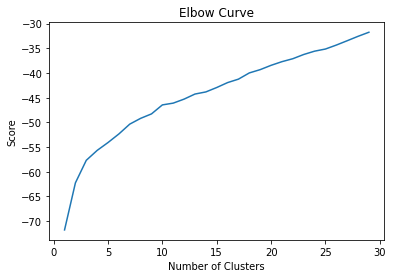

In [ ]:


narray = dfVectoresEncabezados.to_numpy()

Nc = range(2, 30)
kmeans = [KMeans(n_clusters=i) for i in Nc]
# score = [kmeans[i].fit(narray).score(narray) for i in range(len(kmeans))]
score = [kmeans[i].fit(preprocessing.normalize(narray)).score(preprocessing.normalize(narray)) for i in range(len(kmeans))]


plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

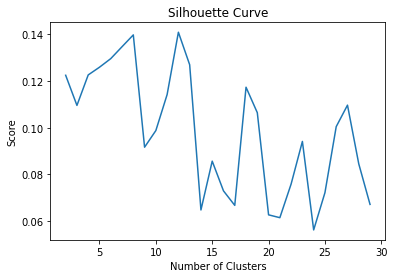

In [ ]:
score = []
Nc = range(2, 30)
for i in Nc:
  kmeans = KMeans(n_clusters=i)
  # kmeans.fit_predict(narray)
  kmeans.fit_predict(preprocessing.normalize(narray))
  # score.append(silhouette_score(narray, kmeans.labels_, metric='euclidean'))
  score.append(silhouette_score(preprocessing.normalize(narray), kmeans.labels_, metric='euclidean'))

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Curve')
plt.show()

In [ ]:
# kmeans = KMeans(n_clusters=6).fit(narray)
kmeans = KMeans(n_clusters=12).fit(preprocessing.normalize(narray))
# labels = kmeans.predict(narray)
labels = kmeans.predict(preprocessing.normalize(narray))

dfResultadosClustering = pd.DataFrame({'Encabezados': dfParaCluster['Encabezado'],
                                       'Cluster': labels})
dfResultadosClustering

,Encabezados,Cluster
0,Order Flow – Imbalance,6
1,¿Qué es order flow?,6
2,Obtenga Order Flow +,6
3,Order Flow – Absorción/Contrapartida,6
4,5. Significado de colores en Order Flow,6
...,...,...
130,7. ¿Qué son los imbalances?,1
131,Brókers para Acciones y ETFs,1
132,Descrubre todo lo que te ofrece nuestro curso ...,1
133,Guías para traders,9


In [ ]:
dfResultadosClustering['Cluster']

## V2: Cluster con PCA

In [ ]:
from sklearn.decomposition import PCA
arrayParaPCA = dfVectoresEncabezados.to_numpy()

pca = PCA(n_components=15)
PCA_result = pca.fit_transform(arrayParaPCA)
sum(pca.explained_variance_ratio_)

0.7274902927416761

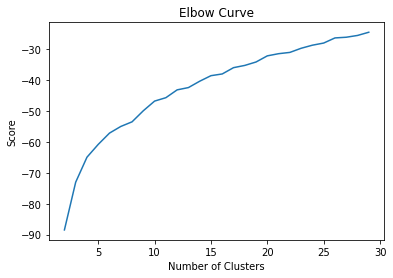

In [ ]:
Nc = range(2, 30)
kmeans = [KMeans(n_clusters=i) for i in Nc]
# score = [kmeans[i].fit(PCA_result).score(PCA_result) for i in range(len(kmeans))]
score = [kmeans[i].fit(preprocessing.normalize(PCA_result)).score(preprocessing.normalize(PCA_result)) for i in range(len(kmeans))]


plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

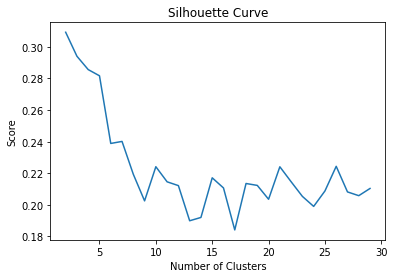

In [ ]:
score = []
Nc = range(2, 30)
for i in Nc:
  kmeans = KMeans(n_clusters=i)
  # kmeans.fit_predict(PCA_result)
  kmeans.fit_predict(preprocessing.normalize(PCA_result))
  # score.append(silhouette_score(PCA_result, kmeans.labels_, metric='euclidean'))
  score.append(silhouette_score(preprocessing.normalize(PCA_result), kmeans.labels_, metric='euclidean'))

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Curve')
plt.show()

In [ ]:
# kmeans = KMeans(n_clusters=6).fit(PCA_result)
kmeans = KMeans(n_clusters=6).fit(preprocessing.normalize(PCA_result))
# labels = kmeans.predict(PCA_result)
labels = kmeans.predict(preprocessing.normalize(PCA_result))

dfResultadosClustering = pd.DataFrame({'Encabezados': dfParaCluster['Encabezado'],
                                       'Cluster': labels})
dfResultadosClustering

,Encabezados,Cluster
0,Order Flow – Imbalance,1
1,¿Qué es order flow?,1
2,Obtenga Order Flow +,1
3,Order Flow – Absorción/Contrapartida,1
4,5. Significado de colores en Order Flow,1
...,...,...
130,7. ¿Qué son los imbalances?,0
131,Brókers para Acciones y ETFs,0
132,Descrubre todo lo que te ofrece nuestro curso ...,0
133,Guías para traders,0


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    PCA_result,
    labels=dfParaCluster['Páginas'],
    dimensions=range(3), #PCA_result.shape[1],
    color=dfResultadosClustering['Cluster'], #dfParaCluster['Páginas'],
    hover_name=dfParaCluster['Encabezado']
)

fig.update_traces(diagonal_visible=False)
fig.show()

## NO SIRVE

In [ ]:
matriz_distancias = []
for encabezado0 in pdHeadingsFinal['Encabezado']:
  fila = []
  for encabezado1 in pdHeadingsFinal['Encabezado']:
    fila.append(similitud(encabezado0, encabezado1))
  matriz_distancias.append(fila)

In [ ]:
for palabra in limpiarFrase(quitarStopWords('Herramientas sobre Mejores hipotecas')).split():
  modelo.wv[palabra]

In [ ]:
from scipy import spatial
a = modelo.wv['banco'] + modelo.wv['mejorar'] + modelo.wv['hipotecar'] + modelo.wv['variable'] + modelo.wv['marzo'] 
b = modelo.wv['herramienta'] + modelo.wv['mejorar'] + modelo.wv['hipotecar']
round(1 - spatial.distance.cosine(a, b), 3)

In [ ]:
similitud('¿Qué bancos tienen las mejores hipotecas variables de marzo de 2022?',
          'Herramientas sobre Mejores hipotecas')

In [ ]:
import numpy as np

texto2Vector('Herramientas sobre Mejores hipotecas', modelo)

In [ ]:
dfDistanciasEncabezados = pd.DataFrame(matriz_distancias, columns = pdHeadingsFinal['Encabezado'])
dfDistanciasEncabezados.index = pdHeadingsFinal['Encabezado']
dfDistanciasEncabezados

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# kmeans = KMeans(n_clusters=4)
# kmeans.fit(matriz_distancias)
# y_kmeans = kmeans.predict(matriz_distancias)


Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(matriz_distancias).score(matriz_distancias) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(matriz_distancias)
y_kmeans = kmeans.predict(matriz_distancias)

dfResultadosClustering = pd.DataFrame({'Encabezados': pdHeadingsFinal['Encabezado'],
                                       'Cluster': y_kmeans})

In [ ]:
dfResultadosClustering